# <span style="color:purple">Question answering using transformers</span>

## 1. Loading dataset

- SQAUD dataset that contains more than 100 000 questions and anwers will be used for training and evaluating model, but for our purposes training and validation set will be limited to 5000 and 500 instances.

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DefaultDataCollator
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
import pandas as pd
from tqdm.auto import tqdm
import collections
from collections import defaultdict
import numpy as np
import evaluate

2024-09-26 20:28:39.600527: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 20:28:40.188476: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 20:28:41.137071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
squad = load_dataset("squad")
squad = squad.shuffle(seed=10)

squad_val = squad["validation"].select(range(500))
squad_train = squad["train"].select(range(5000))

- One instance from train dataset contains: id, title, context, question, answer and answer_start.

In [4]:
squad_train[0]

{'id': '572e86b8dfa6aa1500f8d0aa',
 'title': 'Richard_Feynman',
 'context': 'Feynman has been called the "Great Explainer". He gained a reputation for taking great care when giving explanations to his students and for making it a moral duty to make the topic accessible. His guiding principle was that, if a topic could not be explained in a freshman lecture, it was not yet fully understood. Feynman gained great pleasure from coming up with such a "freshman-level" explanation, for example, of the connection between spin and statistics. What he said was that groups of particles with spin ½ "repel", whereas groups with integer spin "clump". This was a brilliantly simplified way of demonstrating how Fermi–Dirac statistics and Bose–Einstein statistics evolved as a consequence of studying how fermions and bosons behave under a rotation of 360°. This was also a question he pondered in his more advanced lectures, and to which he demonstrated the solution in the 1986 Dirac memorial lecture. In t

In [4]:
squad_val[0]

{'id': '57106644b654c5140001f8e7',
 'title': 'Huguenot',
 'context': 'The availability of the Bible in vernacular languages was important to the spread of the Protestant movement and development of the Reformed church in France. The country had a long history of struggles with the papacy by the time the Protestant Reformation finally arrived. Around 1294, a French version of the Scriptures was prepared by the Roman Catholic priest, Guyard de Moulin. A two-volume illustrated folio paraphrase version based on his manuscript, by Jean de Rély, was printed in Paris in 1487.',
 'question': 'Who translated this version of the scriptures?',
 'answers': {'text': ['Guyard de Moulin',
   'Guyard de Moulin',
   'Guyard de Moulin'],
  'answer_start': [366, 366, 366]}}

## 2. Peprocess data

- Tokenizer is used to prepare data to be in correct format for model. Each token is representing one word, it is represented as an integer and model can understand meaning.
- Pretraind tokenizer distilBert that already contains vocabulary will be used.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
def preprocess_train_data(train_dataset):
    questions = [q.strip() for q in train_dataset["question"]]
    inputs = tokenizer(
        questions,
        train_dataset["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    #offset_mapping contains information about mapping tokens to original text
    offset_mapping = inputs.pop("offset_mapping")
    answers = train_dataset["answers"]
    start_positions = []
    end_positions = []
    
    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i) #sequence_ids for context token is 1, for question token is 0
        
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1
    
        #if the answer is not inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)
    
            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    #start_positions, end_positions contains tokens of start and end of answer
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [7]:
def preprocess_validation_data(val_dataset):
    questions = [q.strip() for q in val_dataset["question"]]
    inputs = tokenizer(
        questions,
        val_dataset["context"],
        max_length=384,
        truncation="only_second",
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    #sample_map indicates which chunk of tokenized data corresponds to original data, it is necessary because context can be too long
    #and splitted to more than one chunk
    #sample_map[i] will give index of original data, from which is this chunk made
    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(val_dataset["id"][sample_idx])

        #tokens for questions are marked as None, so model can focus on context
        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)]
    #example_ids are original ids for original data, it is used to track from where each chunk is coming
    inputs["example_id"] = example_ids
    return inputs

In [8]:
tokenized_train = squad_train.map(preprocess_train_data, batched=True, remove_columns=squad_train.column_names)
tokenized_val = squad_val.map(preprocess_validation_data, batched=True, remove_columns=squad_val.column_names)

## 3. Training and evaluating

- Pretrained model distilBert is used for training, data collator will help to prepare data for training and evaluation.

In [9]:
model = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-uncased")
data_collator = DefaultDataCollator()

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- Function compute_metrics is used to evaluate models predictions.

In [10]:
n_best = 20
max_answer_length = 30
metric = evaluate.load("squad")

In [11]:
#start_logits, end_logits: models predictions of start and end of answer in context
#features: offset_mappings and example_ids of original data
#examples: original data
def compute_metrics(start_logits, end_logits, features, examples):
    #dict is used to map featues to original data
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        #loop through all features that are associated with current example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            #finding tokens with highest predicted value for start and end of an answer
            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    #skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    #skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    #construction of list answers that contains list of possible answers with highest predicted values
                    answers.append(answer)

        #select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [13]:
learning_rates = [1e-5, 3e-5]
batch_sizes = [8, 16]
num_epochs = [2, 3]
results = []

In [14]:
for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in num_epochs:
            training_args = TrainingArguments(
                output_dir="dir",
                learning_rate=lr,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                num_train_epochs=epochs,
                weight_decay=0.01,
                eval_strategy="steps",
                logging_steps=200
                
            )

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_val,
                tokenizer=tokenizer,
                data_collator=data_collator,
            )

            trainer.train()
            eval_results = trainer.evaluate()

            predictions, _, _ = trainer.predict(tokenized_val)
            start_logits, end_logits = predictions
            metrics = compute_metrics(start_logits, end_logits, tokenized_val, squad_val)
            print(metrics)

            results.append({
                "learning_rate": lr,
                "batch_size": batch_size,
                "num_epochs": epochs,
                "exact_match": metrics['exact_match'],
                "f1": metrics['f1'],
            })

Step,Training Loss,Validation Loss
200,4.605900,No log
400,3.667400,No log
600,3.139600,No log
800,2.547700,No log
1000,2.487800,No log
1200,2.397700,No log


100%|████████████████████████████████████████| 500/500 [00:00<00:00, 913.45it/s]


{'exact_match': 36.8, 'f1': 48.61963145682969}


Step,Training Loss,Validation Loss
200,2.264600,No log
400,2.076800,No log
600,1.958700,No log
800,1.581100,No log
1000,1.661000,No log
1200,1.706900,No log
1400,1.566100,No log
1600,1.476100,No log
1800,1.399800,No log


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 483.27it/s]


{'exact_match': 46.2, 'f1': 57.47988739602279}


Step,Training Loss,Validation Loss
200,1.399700,No log
400,1.227200,No log
600,1.168100,No log


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1560.40it/s]


{'exact_match': 49.4, 'f1': 59.69579704619076}


Step,Training Loss,Validation Loss
200,0.836600,No log
400,0.803800,No log
600,0.857900,No log
800,0.808900,No log


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1527.90it/s]


{'exact_match': 50.4, 'f1': 61.534542538297075}


Step,Training Loss,Validation Loss
200,0.739100,No log
400,0.757400,No log
600,0.787300,No log
800,0.373700,No log
1000,0.410800,No log
1200,0.425400,No log


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1400.09it/s]


{'exact_match': 50.0, 'f1': 61.14471180153722}


Step,Training Loss,Validation Loss
200,0.207300,No log
400,0.206300,No log
600,0.229600,No log
800,0.129300,No log
1000,0.179200,No log
1200,0.290500,No log
1400,0.247300,No log
1600,0.197700,No log
1800,0.202500,No log


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1268.24it/s]


{'exact_match': 47.4, 'f1': 59.99834181416179}


Step,Training Loss,Validation Loss
200,0.122200,No log
400,0.122700,No log
600,0.109600,No log


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1484.65it/s]


{'exact_match': 48.8, 'f1': 62.32034547850343}


Step,Training Loss,Validation Loss
200,0.056000,No log
400,0.047300,No log
600,0.060200,No log
800,0.082700,No log


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1614.34it/s]


{'exact_match': 49.0, 'f1': 61.272149159260536}


## 4. Ploting results

In [15]:
results_df = pd.DataFrame(results)

In [16]:
results_df

,learning_rate,batch_size,num_epochs,exact_match,f1
0,0.00001,8,2,36.8,48.619631
1,0.00001,8,3,46.2,57.479887
2,0.00001,16,2,49.4,59.695797
3,0.00001,16,3,50.4,61.534543
4,0.00003,8,2,50.0,61.144712
5,0.00003,8,3,47.4,59.998342
6,0.00003,16,2,48.8,62.320345
7,0.00003,16,3,49.0,61.272149


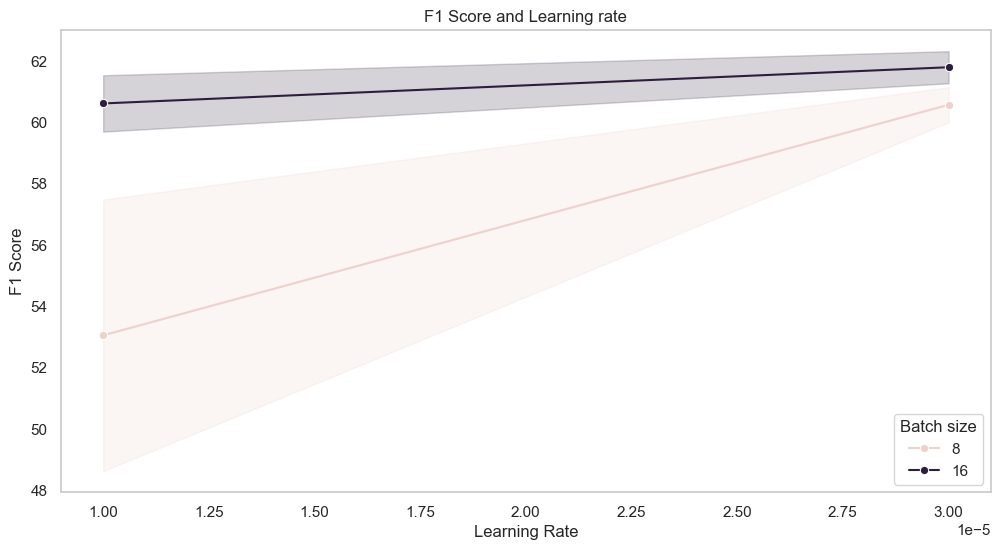

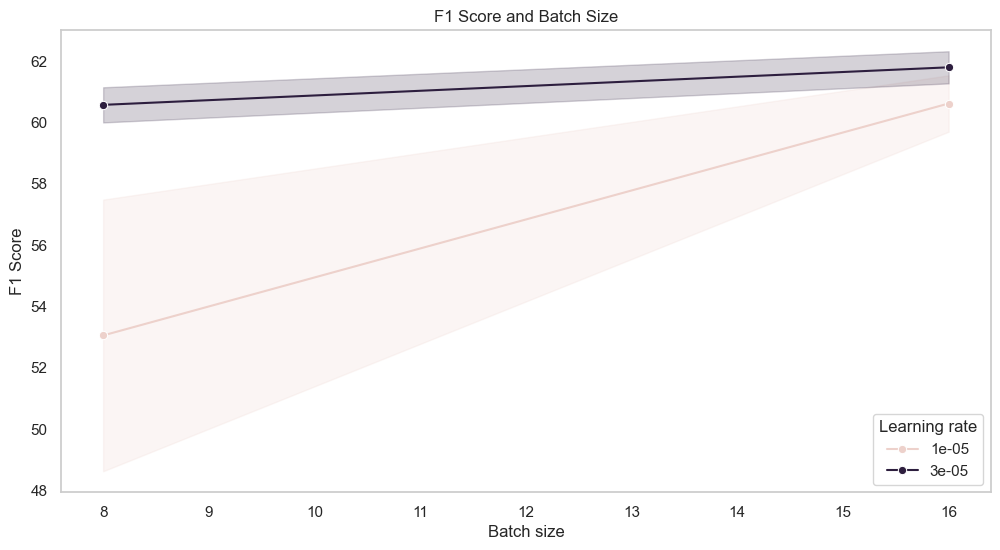

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="learning_rate", y="f1", hue="batch_size", marker='o')
plt.title("F1 Score and Learning rate")
plt.xlabel("Learning Rate")
plt.ylabel("F1 Score")
plt.legend(title="Batch size")
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="batch_size", y="f1", hue="learning_rate", marker='o')
plt.title("F1 Score and Batch Size")
plt.xlabel("Batch size")
plt.ylabel("F1 Score")
plt.legend(title="Learning rate")
plt.grid()
plt.show()